## Импорты и настройка окружения

In [59]:
import os
import time
import re
from enum import Enum


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import mlflow
from mlflow.models.signature import infer_signature

from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, models, transforms

from tqdm import tqdm, trange
from pyngrok import ngrok



In [60]:
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git
torch.cuda.is_available()

False

In [61]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


## Трансформация

In [62]:
distortion_scale = 0.2

In [63]:
class ToCenter(torch.nn.Module):
    def __init__(
        self,
        size: int = 28
    ):
        super(ToCenter, self).__init__()

        assert size % 2 == 0, 'Size must be even'
        
        self._size = size
        self._offset = size // 2

    def forward(self, img):
        
        img_array = np.array(img)
        rows = np.any(img_array > 0, axis=1)
        cols = np.any(img_array > 0, axis=0) 
   
        row_nonzero = np.where(rows)[0]
        col_nonzero = np.where(cols)[0]

        if row_nonzero.size: 
            top, bottom = row_nonzero[[0, -1]]
        else:  # изображение полностью из нулей
            top, bottom = 0, 0

        if col_nonzero.size:
            left, right = col_nonzero[[0, -1]]
        else:
            left, right = 0, 0

        resize_img=img_array[top:bottom+1, left:right+1] / 255
        result = np.zeros((28, 28))

        row_start = int(self._offset - (bottom - top) / 2)
        row_end = int(self._offset + (bottom - top) / 2 + 1)
        col_start = int(self._offset  - (right - left) / 2)
        col_end = int(self._offset + (right - left) / 2 + 1)
        result[row_start: row_end, col_start:col_end] = resize_img
        

        img_result = Image.fromarray(result)
        
        return img_result
   

In [65]:
transform = transforms.Compose([
    ToCenter(),
    #transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    #transforms. ElasticTransform(alpha=50.0 ),
    #transforms.RandomRotation(degrees=10.0),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.5, 1)),
    transforms.RandomPerspective(p=0.9, distortion_scale=distortion_scale),
    #transforms.RandomResizedCrop(size=(28, 28),scale=(0.7, 0.8), ratio=(0.7, 0.8)),
    transforms.ToTensor()
])

In [66]:
transform_test = transforms.Compose([
    ToCenter(),
    transforms.ToTensor()
])

In [67]:
def get_transform():
    try:
        transform
    except NameError:
        return transforms.Compose([transforms.ToTensor()])
    else:
        return transform

In [68]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt_ax.imshow(inp)
    
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Погрузка и настройка данных

In [39]:
generator1 = torch.Generator().manual_seed(42)

dataset_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataset_train_augm = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataset = torch.utils.data.ConcatDataset(
    [dataset_train, dataset_train_augm]
)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_test)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=generator1)

DEVICE = torch.device("cpu")

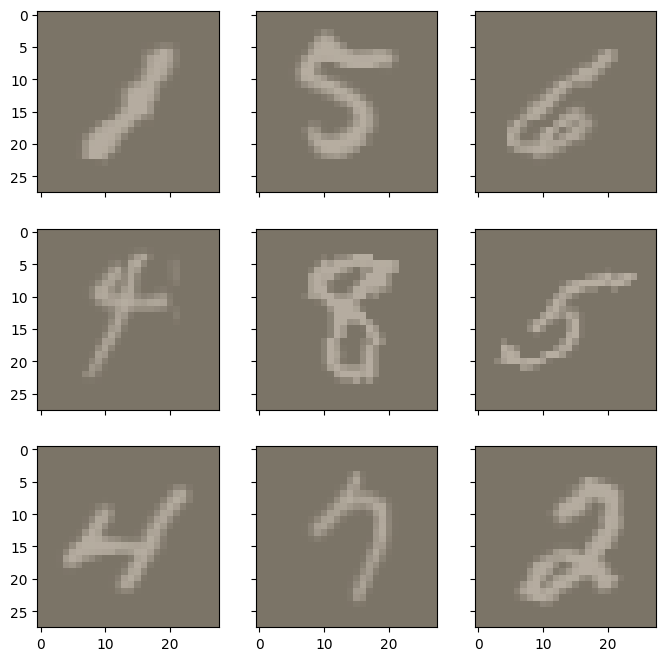

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset_train_augm[random_characters]
    
    imshow(im_val.data.cpu(), plt_ax=fig_x)

## Методы обучения, предсказания и оценки

In [41]:
class Timer:
    def __enter__(self):
        self._start = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self._end = time.time()

    def __str__(self):
        num = self.float_round()
        return f'{num} seconds'
    
    def float_round(self, cnt_numbers: int = 4) -> float:
        return round(self._end - self._start, cnt_numbers)

In [42]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data_count = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data_count += inputs.size(0)

    train_loss = running_loss / processed_data_count
    train_acc = running_corrects.cpu().numpy() / processed_data_count

    return train_loss, train_acc

In [43]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    return val_loss, val_acc

In [44]:
def train(train_files, val_files, model, epochs: int, batch_size: int, num_samples: int):
    train_sampler=torch.utils.data.RandomSampler(train_dataset, num_samples=num_samples)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler) # shuffle=True,sampler=train_sampler
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [45]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            if isinstance(inputs, tuple) or isinstance(inputs, list) and len(inputs) == 2:
                # if the loader is really loader, then it returns tuple(X, y)
                inputs = inputs[0]

            inputs = inputs.to(DEVICE)
            model.eval()
            
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Архитектуры

### Архитектура EnsNet

In [668]:
class EnsNet(nn.Module):
  def __init__(self, num_classes=10):
      super(EnsNet, self).__init__()
      self.features = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.35),
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        nn.Conv2d(512, 1024, kernel_size=3),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.35),
        
      )
      self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
      self.classifier_major = nn.Linear(216, num_classes)
      self.classifiers = nn.ModuleList([
          nn.Linear(216, num_classes)
          for _ in range(10)
      ])
      self.weights = nn.Parameter(torch.ones(11) / 11, requires_grad=True)

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x_major = self.classifier_major(x[:, :216])
    x_rest = [classifier(x[:, 216 * i :216 * (i + 1) ]) for i, classifier in enumerate(self.classifiers)]
    all_x = torch.stack([x_major] + x_rest, dim=1)
    weighted_x = torch.sum(all_x * self.weights.view(1, -1, 1), dim=1)
    return weighted_x

### AlexNet

In [40]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

### VGG8

In [39]:
class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=(3,3)),  nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))

        self.conv4 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(3,3)), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(5184, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 128), nn.ReLU())
        self.fc3 = nn.Linear(128,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### ResNet

In [17]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      )
  def forward(self, x):
    out = nn.ReLU(inplace=True)(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = nn.ReLU(inplace=True)(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 16

    self.model = nn.Sequential(
      nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
      self._make_layer(16, 2, stride=1),
      self._make_layer(32, 2, stride=2),
      self._make_layer(64, 2, stride=2),
      self._make_layer(128, 2, stride=2),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(start_dim=1),
      nn.Linear(128, num_classes)
  )
    self._initialize_weights()

  def _make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_channels, out_channels, stride))
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

### LeNet

In [46]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), nn.ReLU(), nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.conv2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),nn.MaxPool2d(stride=1, kernel_size=(2*2)))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(3136, 120), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.ReLU())
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

### Подгрузка модели

In [47]:
class NNNetEnum(Enum):
    ens_net = 1
    alex_net = 2
    vgg8 = 3
    res_net = 4
    le_net = 5

In [48]:
def get_nn_model(nn_model: NNNetEnum):
    model_class = None
    if nn_model == NNNetEnum.ens_net:
        model_class =  EnsNet
    if nn_model == NNNetEnum.alex_net:
        model_class =  AlexNet
    if nn_model == NNNetEnum.vgg8:
        model_class =  VGG8
    if nn_model == NNNetEnum.res_net:
        model_class =  ResNet
    if nn_model == NNNetEnum.le_net:
        model_class =  LeNet

    if model_class is None:
        raise Exception(f'The passed architecture {nn_model} was not found. Check enum conditions.')
    
    return model_class().to(DEVICE)

## Тесты архитектур

In [49]:
simple_cnn = get_nn_model(NNNetEnum.le_net)

In [50]:
epoch = 60
batch_size = 64
num_samples = 5000

In [51]:
with Timer() as train_timer:
    history = train(train_dataset, val_dataset, model=simple_cnn, epochs=epoch, batch_size=batch_size, num_samples=num_samples)

epoch:   0%|                                                                                    | 0/60 [00:00<?, ?it/s]

loss 1.1028970876693727


epoch:   2%|█▎                                                                          | 1/60 [00:09<09:01,  9.18s/it]


Epoch 001 train_loss: 1.1029     val_loss 0.4478 train_acc 0.6482 val_acc 0.8602
loss 0.39352341735363006


epoch:   3%|██▌                                                                         | 2/60 [00:18<09:08,  9.46s/it]


Epoch 002 train_loss: 0.3935     val_loss 0.3237 train_acc 0.8740 val_acc 0.8985
loss 0.26920304915904997


epoch:   5%|███▊                                                                        | 3/60 [00:28<08:55,  9.40s/it]


Epoch 003 train_loss: 0.2692     val_loss 0.2464 train_acc 0.9182 val_acc 0.9232
loss 0.22519897089004517


epoch:   7%|█████                                                                       | 4/60 [00:37<08:44,  9.36s/it]


Epoch 004 train_loss: 0.2252     val_loss 0.2051 train_acc 0.9334 val_acc 0.9375
loss 0.19965712928771973


epoch:   8%|██████▎                                                                     | 5/60 [00:46<08:38,  9.42s/it]


Epoch 005 train_loss: 0.1997     val_loss 0.2124 train_acc 0.9372 val_acc 0.9313
loss 0.17621357839107513


epoch:  10%|███████▌                                                                    | 6/60 [00:56<08:27,  9.41s/it]


Epoch 006 train_loss: 0.1762     val_loss 0.1462 train_acc 0.9460 val_acc 0.9546
loss 0.1395266133785248


epoch:  12%|████████▊                                                                   | 7/60 [01:05<08:18,  9.40s/it]


Epoch 007 train_loss: 0.1395     val_loss 0.1634 train_acc 0.9554 val_acc 0.9477
loss 0.15879341270923614


epoch:  13%|██████████▏                                                                 | 8/60 [01:14<08:06,  9.35s/it]


Epoch 008 train_loss: 0.1588     val_loss 0.1695 train_acc 0.9470 val_acc 0.9484
loss 0.1398656570315361


epoch:  15%|███████████▍                                                                | 9/60 [01:24<08:07,  9.55s/it]


Epoch 009 train_loss: 0.1399     val_loss 0.1299 train_acc 0.9572 val_acc 0.9591
loss 0.12623453314006328


epoch:  17%|████████████▌                                                              | 10/60 [01:34<07:58,  9.56s/it]


Epoch 010 train_loss: 0.1262     val_loss 0.1523 train_acc 0.9606 val_acc 0.9507
loss 0.12688010202646255


epoch:  18%|█████████████▋                                                             | 11/60 [01:44<07:48,  9.57s/it]


Epoch 011 train_loss: 0.1269     val_loss 0.1812 train_acc 0.9622 val_acc 0.9473
loss 0.121296435546875


epoch:  20%|███████████████                                                            | 12/60 [01:53<07:36,  9.51s/it]


Epoch 012 train_loss: 0.1213     val_loss 0.1208 train_acc 0.9598 val_acc 0.9618
loss 0.12526615659296514


epoch:  22%|████████████████▎                                                          | 13/60 [02:02<07:26,  9.49s/it]


Epoch 013 train_loss: 0.1253     val_loss 0.1259 train_acc 0.9600 val_acc 0.9590
loss 0.12192793831825256


epoch:  23%|█████████████████▌                                                         | 14/60 [02:12<07:17,  9.50s/it]


Epoch 014 train_loss: 0.1219     val_loss 0.1237 train_acc 0.9608 val_acc 0.9620
loss 0.10010999485477805


epoch:  25%|██████████████████▊                                                        | 15/60 [02:22<07:10,  9.56s/it]


Epoch 015 train_loss: 0.1001     val_loss 0.1207 train_acc 0.9700 val_acc 0.9613
loss 0.09631322069168091


epoch:  27%|████████████████████                                                       | 16/60 [02:31<06:59,  9.54s/it]


Epoch 016 train_loss: 0.0963     val_loss 0.1009 train_acc 0.9700 val_acc 0.9695
loss 0.0999664156600833


epoch:  28%|█████████████████████▎                                                     | 17/60 [02:41<06:48,  9.51s/it]


Epoch 017 train_loss: 0.1000     val_loss 0.1000 train_acc 0.9658 val_acc 0.9684
loss 0.07725888962298631


epoch:  30%|██████████████████████▌                                                    | 18/60 [02:50<06:37,  9.47s/it]


Epoch 018 train_loss: 0.0773     val_loss 0.1110 train_acc 0.9762 val_acc 0.9645
loss 0.09148047460317611


epoch:  32%|███████████████████████▊                                                   | 19/60 [02:59<06:22,  9.33s/it]


Epoch 019 train_loss: 0.0915     val_loss 0.0956 train_acc 0.9714 val_acc 0.9687
loss 0.08399430704116821


epoch:  33%|█████████████████████████                                                  | 20/60 [03:08<06:11,  9.29s/it]


Epoch 020 train_loss: 0.0840     val_loss 0.1035 train_acc 0.9724 val_acc 0.9694
loss 0.08483340442180634


epoch:  35%|██████████████████████████▎                                                | 21/60 [03:17<05:58,  9.18s/it]


Epoch 021 train_loss: 0.0848     val_loss 0.1015 train_acc 0.9738 val_acc 0.9673
loss 0.08230232469439507


epoch:  37%|███████████████████████████▍                                               | 22/60 [03:26<05:49,  9.19s/it]


Epoch 022 train_loss: 0.0823     val_loss 0.0894 train_acc 0.9764 val_acc 0.9730
loss 0.07717436036467552


epoch:  38%|████████████████████████████▊                                              | 23/60 [03:36<05:41,  9.22s/it]


Epoch 023 train_loss: 0.0772     val_loss 0.0999 train_acc 0.9746 val_acc 0.9698
loss 0.07978497520685196


epoch:  40%|██████████████████████████████                                             | 24/60 [03:46<05:47,  9.65s/it]


Epoch 024 train_loss: 0.0798     val_loss 0.1061 train_acc 0.9738 val_acc 0.9666
loss 0.08177988315224648


epoch:  42%|███████████████████████████████▎                                           | 25/60 [03:56<05:41,  9.77s/it]


Epoch 025 train_loss: 0.0818     val_loss 0.1398 train_acc 0.9752 val_acc 0.9571
loss 0.07728220607638359


epoch:  43%|████████████████████████████████▌                                          | 26/60 [04:06<05:35,  9.86s/it]


Epoch 026 train_loss: 0.0773     val_loss 0.1023 train_acc 0.9780 val_acc 0.9670
loss 0.07569956180453301


epoch:  45%|█████████████████████████████████▊                                         | 27/60 [04:16<05:20,  9.72s/it]


Epoch 027 train_loss: 0.0757     val_loss 0.0983 train_acc 0.9780 val_acc 0.9679
loss 0.08119062376320361


epoch:  47%|███████████████████████████████████                                        | 28/60 [04:25<05:08,  9.63s/it]


Epoch 028 train_loss: 0.0812     val_loss 0.0941 train_acc 0.9752 val_acc 0.9707
loss 0.06988996843993664


epoch:  48%|████████████████████████████████████▎                                      | 29/60 [04:35<04:55,  9.54s/it]


Epoch 029 train_loss: 0.0699     val_loss 0.0926 train_acc 0.9780 val_acc 0.9699
loss 0.06962464382648469


epoch:  50%|█████████████████████████████████████▌                                     | 30/60 [04:44<04:47,  9.60s/it]


Epoch 030 train_loss: 0.0696     val_loss 0.0805 train_acc 0.9794 val_acc 0.9761
loss 0.06818116546720267


epoch:  52%|██████████████████████████████████████▊                                    | 31/60 [04:54<04:38,  9.62s/it]


Epoch 031 train_loss: 0.0682     val_loss 0.0864 train_acc 0.9790 val_acc 0.9738
loss 0.07320056990385056


epoch:  53%|████████████████████████████████████████                                   | 32/60 [05:04<04:30,  9.68s/it]


Epoch 032 train_loss: 0.0732     val_loss 0.0887 train_acc 0.9768 val_acc 0.9722
loss 0.08529769136756658


epoch:  55%|█████████████████████████████████████████▎                                 | 33/60 [05:13<04:19,  9.61s/it]


Epoch 033 train_loss: 0.0853     val_loss 0.0813 train_acc 0.9730 val_acc 0.9744
loss 0.06985725985169411


epoch:  57%|██████████████████████████████████████████▌                                | 34/60 [05:23<04:08,  9.55s/it]


Epoch 034 train_loss: 0.0699     val_loss 0.0823 train_acc 0.9800 val_acc 0.9742
loss 0.06224372843336314


epoch:  58%|███████████████████████████████████████████▊                               | 35/60 [05:32<03:58,  9.56s/it]


Epoch 035 train_loss: 0.0622     val_loss 0.0744 train_acc 0.9794 val_acc 0.9772
loss 0.06832794629037381


epoch:  60%|█████████████████████████████████████████████                              | 36/60 [05:42<03:49,  9.54s/it]


Epoch 036 train_loss: 0.0683     val_loss 0.0773 train_acc 0.9790 val_acc 0.9757
loss 0.061663007682561874


epoch:  62%|██████████████████████████████████████████████▎                            | 37/60 [05:51<03:40,  9.57s/it]


Epoch 037 train_loss: 0.0617     val_loss 0.0711 train_acc 0.9796 val_acc 0.9763
loss 0.08198586075305939


epoch:  63%|███████████████████████████████████████████████▌                           | 38/60 [06:01<03:28,  9.47s/it]


Epoch 038 train_loss: 0.0820     val_loss 0.0757 train_acc 0.9730 val_acc 0.9772
loss 0.07376151533070952


epoch:  65%|████████████████████████████████████████████████▊                          | 39/60 [06:10<03:16,  9.37s/it]


Epoch 039 train_loss: 0.0738     val_loss 0.1164 train_acc 0.9764 val_acc 0.9635
loss 0.05858914077281952


epoch:  67%|██████████████████████████████████████████████████                         | 40/60 [06:19<03:06,  9.33s/it]


Epoch 040 train_loss: 0.0586     val_loss 0.0861 train_acc 0.9824 val_acc 0.9722
loss 0.056565720783919096


epoch:  68%|███████████████████████████████████████████████████▎                       | 41/60 [06:28<02:57,  9.34s/it]


Epoch 041 train_loss: 0.0566     val_loss 0.0746 train_acc 0.9796 val_acc 0.9777
loss 0.07272889054194093


epoch:  70%|████████████████████████████████████████████████████▌                      | 42/60 [06:38<02:47,  9.32s/it]


Epoch 042 train_loss: 0.0727     val_loss 0.0763 train_acc 0.9774 val_acc 0.9762
loss 0.07722218584418297


epoch:  72%|█████████████████████████████████████████████████████▊                     | 43/60 [06:47<02:38,  9.34s/it]


Epoch 043 train_loss: 0.0772     val_loss 0.0837 train_acc 0.9782 val_acc 0.9734
loss 0.06011170303807594


epoch:  73%|██████████████████████████████████████████████████████▉                    | 44/60 [06:56<02:29,  9.32s/it]


Epoch 044 train_loss: 0.0601     val_loss 0.0792 train_acc 0.9788 val_acc 0.9760
loss 0.054767300901561976


epoch:  75%|████████████████████████████████████████████████████████▎                  | 45/60 [07:06<02:19,  9.30s/it]


Epoch 045 train_loss: 0.0548     val_loss 0.0767 train_acc 0.9828 val_acc 0.9760
loss 0.062138421201705936


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 46/60 [07:15<02:10,  9.33s/it]


Epoch 046 train_loss: 0.0621     val_loss 0.0715 train_acc 0.9804 val_acc 0.9771
loss 0.05621184846451506


epoch:  78%|██████████████████████████████████████████████████████████▊                | 47/60 [07:24<02:01,  9.38s/it]


Epoch 047 train_loss: 0.0562     val_loss 0.0767 train_acc 0.9808 val_acc 0.9762
loss 0.07355762608274817


epoch:  80%|████████████████████████████████████████████████████████████               | 48/60 [07:34<01:53,  9.42s/it]


Epoch 048 train_loss: 0.0736     val_loss 0.0699 train_acc 0.9778 val_acc 0.9782
loss 0.060816845530178396


epoch:  82%|█████████████████████████████████████████████████████████████▎             | 49/60 [07:43<01:43,  9.42s/it]


Epoch 049 train_loss: 0.0608     val_loss 0.0683 train_acc 0.9796 val_acc 0.9790
loss 0.0611475384313846


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 50/60 [07:53<01:34,  9.45s/it]


Epoch 050 train_loss: 0.0611     val_loss 0.0724 train_acc 0.9800 val_acc 0.9771
loss 0.06373488766700029


epoch:  85%|███████████████████████████████████████████████████████████████▊           | 51/60 [08:02<01:25,  9.46s/it]


Epoch 051 train_loss: 0.0637     val_loss 0.0665 train_acc 0.9808 val_acc 0.9788
loss 0.06414240393936634


epoch:  87%|█████████████████████████████████████████████████████████████████          | 52/60 [08:11<01:14,  9.37s/it]


Epoch 052 train_loss: 0.0641     val_loss 0.0760 train_acc 0.9808 val_acc 0.9752
loss 0.0646145037382841


epoch:  88%|██████████████████████████████████████████████████████████████████▎        | 53/60 [08:21<01:05,  9.41s/it]


Epoch 053 train_loss: 0.0646     val_loss 0.0744 train_acc 0.9782 val_acc 0.9762
loss 0.048368530168011785


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 54/60 [08:30<00:56,  9.36s/it]


Epoch 054 train_loss: 0.0484     val_loss 0.0696 train_acc 0.9870 val_acc 0.9790
loss 0.05792866730056703


epoch:  92%|████████████████████████████████████████████████████████████████████▊      | 55/60 [08:40<00:46,  9.38s/it]


Epoch 055 train_loss: 0.0579     val_loss 0.0801 train_acc 0.9834 val_acc 0.9744
loss 0.05605703810825944


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 56/60 [08:49<00:37,  9.33s/it]


Epoch 056 train_loss: 0.0561     val_loss 0.0636 train_acc 0.9816 val_acc 0.9800
loss 0.04747190660238266


epoch:  95%|███████████████████████████████████████████████████████████████████████▎   | 57/60 [08:58<00:27,  9.26s/it]


Epoch 057 train_loss: 0.0475     val_loss 0.0701 train_acc 0.9852 val_acc 0.9776
loss 0.07111975150108338


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 58/60 [09:07<00:18,  9.21s/it]


Epoch 058 train_loss: 0.0711     val_loss 0.0612 train_acc 0.9774 val_acc 0.9812
loss 0.052178631067276


epoch:  98%|█████████████████████████████████████████████████████████████████████████▊ | 59/60 [09:16<00:09,  9.21s/it]


Epoch 059 train_loss: 0.0522     val_loss 0.0660 train_acc 0.9842 val_acc 0.9808
loss 0.05583233566023409


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 60/60 [09:25<00:00,  9.43s/it]


Epoch 060 train_loss: 0.0558     val_loss 0.0560 train_acc 0.9838 val_acc 0.9838


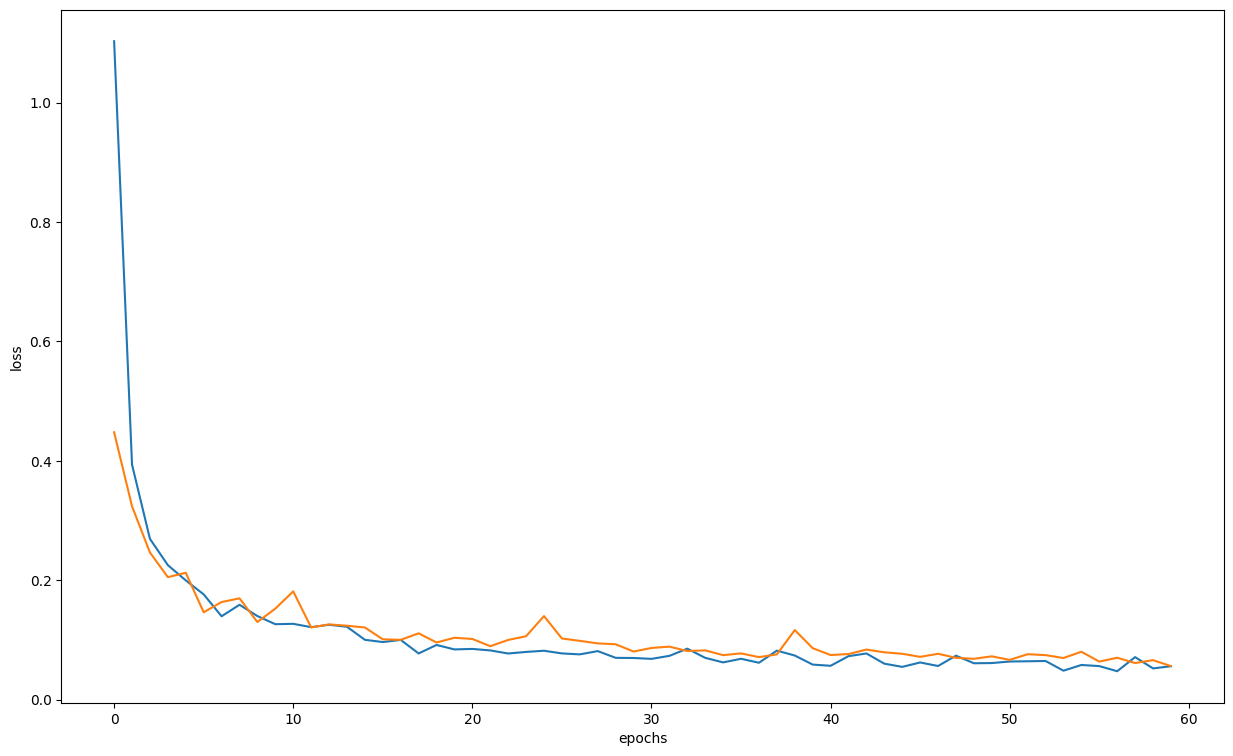

In [52]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [53]:
test_img = [test_dataset[i][0].unsqueeze(0) for i in range(len(test_dataset))]

with Timer() as test_timer:
    test_pred = predict(simple_cnn, test_img)
    y_pred = np.argmax(test_pred,-1)


#### Accuracy по классам

In [54]:
proba_ = predict(simple_cnn, DataLoader(test_dataset, batch_size=1, shuffle=False))
predict_ = np.argmax(proba_, -1)
actual_labels = [el[1] for el in test_dataset]

matrix = confusion_matrix(actual_labels, predict_)
ac_class = matrix.diagonal() / matrix.sum(axis=1)
print('ACCURACY', list(ac_class))

ACCURACY [0.996938775510204, 0.9929515418502203, 0.9883720930232558, 0.9930693069306931, 0.9898167006109979, 0.9809417040358744, 0.9958246346555324, 0.9912451361867705, 0.9835728952772074, 0.9643211100099108]


#### Общий accuracy

In [55]:
actual_labels =[test_dataset[i][1] for i in range(len(test_dataset))]

ac = accuracy_score(actual_labels, y_pred)

print("ACCURACY general:", ac, 'ACCURACY by classes:', sum(ac_class) / 10)

ACCURACY general: 0.9878 ACCURACY by classes: 0.9877053898090665


In [56]:
simple_cnn.__class__.__name__

'LeNet'

## Логирование в MLFlow

In [58]:
model_name = simple_cnn.__class__.__name__

params = {"epoch": epoch, "batch_size": batch_size, "num_samples": num_samples}

for transform_el in get_transform().transforms:
    val = re.sub(r'\w+\(', '', str(transform_el))[:-1]

    if transform_el.__class__.__name__=='ToCenter':
        val='size=(28, 28)'
    
    if not val:
        continue

    if transform_el.__class__.__name__=='RandomPerspective':
        val=f'{val}, distortion_scale={distortion_scale}'

    
    params[transform_el.__class__.__name__] = val


mlflow.set_tracking_uri(uri="sqlite:///mlruns.db")
mlflow.set_experiment(model_name)


with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the metric
    mlflow.log_metric("accuracy", ac)
    mlflow.log_metric("train_time_seconds", train_timer.float_round())
    mlflow.log_metric("pred_time_seconds", test_timer.float_round())

    for i in range(10):
         mlflow.log_metric(f"accuracy_{i}", round(ac_class[i], 5))

    # Log the model
    model_info = mlflow.pytorch.log_model(
        pytorch_model=simple_cnn,
        artifact_path=model_name,
        #signature = infer_signature(train_set_array, train_pred),
        #input_example=train_set_array,
        registered_model_name=model_name,
    )

Registered model 'LeNet' already exists. Creating a new version of this model...
Created version '208' of model 'LeNet'.
